# Autoencoders

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%config InlineBackend.figure_format = 'retina'

## Installation

In [ ]:
# !conda install scikit-learn --yes
# !conda install pytorch -c pytorch --yes
# !pip install tensorflow 
# !pip install multiprocess

## Setup

We begin by importing our dependencies.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from bpr import utils
from bpr import federated
from bpr.common import AEDataset, UserAEDataset 
from bpr.models import Autoencoder, train_autoencoder
import joblib
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Set our seed and other configurations for reproducibility.

In [4]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [5]:
batch_size = 100
epochs = 50
learning_rate = 1e-3

In [6]:
%%time

# Load data

ratings_df = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_df = ratings_df[['user_id', 'item_id', 'rating']]
for column in ['user_id', 'item_id']:
    ratings_df[column] -= 1

ratings_df['rating'] = 1

CPU times: user 24.5 ms, sys: 10.9 ms, total: 35.5 ms
Wall time: 68 ms


## Dataset

In [7]:
n_items = ratings_df['item_id'].nunique()
item_id_max = ratings_df['item_id'].max()
print('Num items  : {:,}'.format(n_items))
print('Max item ID: {:,}'.format(item_id_max))

Num items  : 1,682
Max item ID: 1,681


In [8]:
# %%time
# # Split data

# train_df, test_df = utils.train_test_split(df=ratings_df, loo=True)
# sampler = utils.NegativeSampler(item_ids=ratings_df["item_id"].unique()).fit(
#     train=train_df, test=test_df
# )

# train_df = sampler.transform(train_df, train=True, size=5)
# test_df = sampler.transform(test_df, train=False, size=50)

# train_loader_long = DataLoader(LongDataset(train_df), batch_size=batch_size, shuffle=True)
# test_loader_long = DataLoader(LongDataset(test_df), batch_size=batch_size, shuffle=True)

In [9]:


user_ids = ratings_df['user_id'].unique()
user_ids_train, user_ids_test = train_test_split(user_ids, test_size=0.05)

print(np.setdiff1d(user_ids_train, user_ids_train))

train_df = ratings_df[ratings_df['user_id'].isin(user_ids_train)].copy()
test_df = ratings_df[ratings_df['user_id'].isin(user_ids_test)].copy().reset_index(drop=True)

train_df.set_index(np.arange(train_df.shape[0]))

train_loader_wide = DataLoader(AEDataset(train_df, n_items=n_items), batch_size=batch_size, shuffle=True)
test_loader_wide = DataLoader(AEDataset(test_df, n_items=n_items), batch_size=batch_size, shuffle=True)

[]


## Autoencoder

In [10]:
bottleneck_shape = 10

In [11]:
model, losses = train_autoencoder(
    n_items=n_items,
    learning_rate=learning_rate,
    train_loader=train_loader_wide,
    epochs=epochs,
    bottleneck_shape=10,
)

===using NEW model on client
Mean loss: 0.7312


Text(0.5, 1.0, 'Reconstruction Loss (Central)')

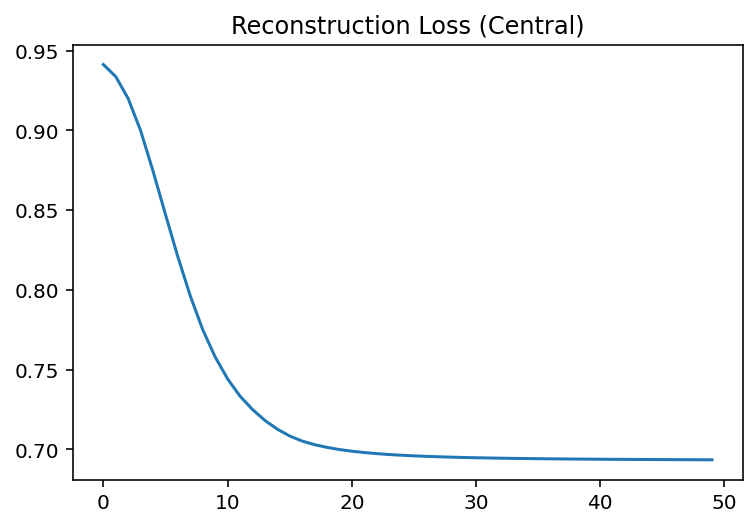

In [12]:
plt.plot(losses)
plt.title("Reconstruction Loss (Central)")

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Autoencoder(input_shape=n_items, bottleneck_shape=10).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()

# train_loader = train_loader_wide


# for epoch in range(epochs):
#     loss = 0

#     for batch_features in train_loader:
#         batch_features = batch_features.to(device)
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         train_loss = criterion(outputs, batch_features)
#         train_loss.backward()
#         optimizer.step()
#         loss += train_loss.item()  # add the mini-batch training loss to epoch loss

#     # compute the epoch training loss
#     loss = loss / len(train_loader)

#     # display the epoch training loss
#     print("epoch : {:0>3}/{:0<3}, recon loss = {:.4f}".format(epoch + 1, epochs, loss))

In [14]:
# # test_loader = torch.utils.data.DataLoader(
# #     test_dataset, batch_size=10, shuffle=False
# # )
# test_loader = test_loader_wide
# test_examples = None

# with torch.no_grad():
#     for batch_features in test_loader:
#         batch_features = batch_features[0]
# #         test_examples = batch_features.view(-1, 784)
#         test_examples = batch_features
#         reconstruction = model(test_examples)
#         break

In [15]:
# wide_dataset = AEDataset(ratings_df, n_items=ratings_df['item_id'].nunique())

# compressed_profiles = {}
# for user_id in ratings_df["user_id"].unique():
#     profile = wide_dataset[wide_dataset.user_id_to_group_idx[user_id]][1]
#     compressed_profiles[user_id] = model.encoder(profile).detach().numpy()

In [16]:
# len(compressed_profiles)

In [17]:

# joblib.dump(compressed_profiles, "compressed-profiles.pkl")

## Federated Autoencoders

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


Text(0.5, 1.0, 'Reconstruction Loss')

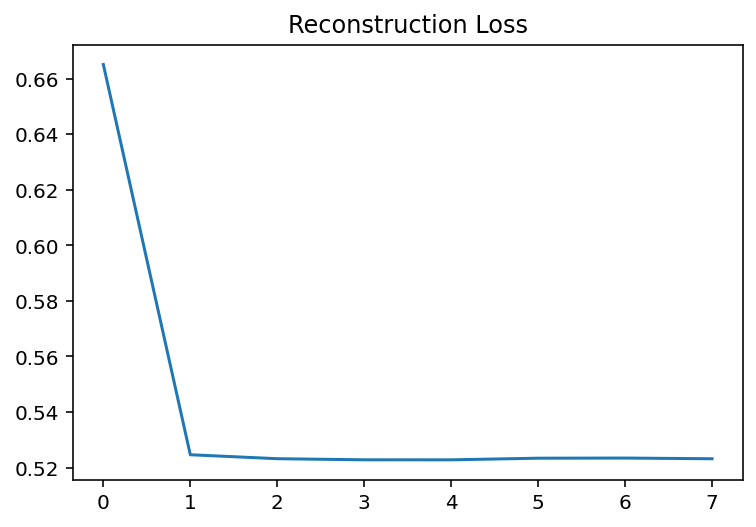

In [18]:
model, test_losses = federated.train(
    batch_size=batch_size,
    bottleneck_size=10,
    epochs=18,
    learning_rate=learning_rate,
    ratings_df=ratings_df,
    rounds=10,
    size=3,
    user_ids=ratings_df["user_id"].unique(),
    users_per_round=90,
    workers=int(mp.cpu_count() * 0.7),
)

plt.plot(test_losses)
plt.title("Reconstruction Loss")

In [22]:
model, test_losses = federated.train(
    batch_size=batch_size,
    bottleneck_size=10,
    epochs=18,
    learning_rate=learning_rate,
    ratings_df=ratings_df,
    rounds=10,
    size=3,
    user_ids=ratings_df["user_id"].unique(),
    users_per_round=90,
    workers=int(mp.cpu_count() * 0.7),
)

plt.plot(test_losses)
plt.title("Reconstruction Loss")

PicklingError: Can't pickle <class 'bpr.models.Autoencoder'>: it's not the same object as bpr.models.Autoencoder

In [20]:
assert 1 == 2

AssertionError: 

In [ ]:
model, test_losses = federated.train(
    batch_size=batch_size,
    bottleneck_size=10,
    epochs=18,
    learning_rate=learning_rate,
    ratings_df=ratings_df,
    rounds=10,
    size=3,
    user_ids=ratings_df["user_id"].unique(),
    users_per_round=90,
    workers=int(mp.cpu_count() * 0.7),
)

plt.plot(test_losses)
plt.title("Reconstruction Loss (Federated)")